In [11]:
#imports
import shdom
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import OrderedDict
import shutil
import datetime as dt
import pylab as py
os.chdir('/Users/jesserl2/Documents/Code/aviad_pyshdom_dev/pyshdom_dev/')
#shdom.util.set_pyshdom_path()
import sys

file_name = './test_forward2.nc'#sys.argv[1]

In [12]:
#Load forward model. Some inputs from the forward problem are used.
#but when using real measurements nothing from 'solvers' will be available.
#'sensor_dict' would also only supply 'cam' variables not 'ray' variables
#in that case.
sensor_dict, solvers, bland =shdom.util.load_forward_model(file_name)

#define an approximate forward_sensor that doesn't have any subpixel rays.
forward_sensors = shdom.util.SensorsDict()#sensor_dict.make_forward_sensors()#

for instrument in sensor_dict:
    sensor_list = sensor_dict[instrument]['sensor_list']
    for sensor in sensor_list:
        approximated_sensor = shdom.sensor.make_sensor_dataset(sensor.cam_x,
                                                               sensor.cam_y,
                                                               sensor.cam_z,
                                                               sensor.cam_mu,
                                                               sensor.cam_phi,
                                                               stokes=['I'],
                                                               wavelength=sensor.wavelength,
                                                               fill_ray_variables=True)
        approximated_sensor['image_shape'] = sensor.image_shape
        forward_sensors.add_sensor(instrument, approximated_sensor)

sensor_dict['MISR']['uncertainty_model'] = shdom.error.IndependentNoise(0.01, relative=False)



In [13]:
wavelengths = forward_sensors.get_unique_solvers()

#define all scattering properties. In general, these will be defined here rather than read from forward problem.
size_distribution_function = shdom.size_distribution.gamma

cloud_poly_tables = OrderedDict() # keeping poly_tables for later use.
for wavelength in wavelengths:
    #mie_table path is hardcoded for now. . .
    mie_mono_table = shdom.mie.get_mono_table('Water',(wavelength,wavelength), relative_path='./mie_tables')
    cloud_size_distribution = shdom.size_distribution.get_size_distribution_grid(
                                                            mie_mono_table.radius.data,
                        size_distribution_function=size_distribution_function,particle_density=1.0,
                        reff=[9.0,11.0,13,'linear','micron'], #reff/veff are not going to be optimized for
                        veff=[0.04,0.6,13,'linear','unitless'],#so only small number of entries in the table.
                        )
    poly_table = shdom.mie.get_poly_table(cloud_size_distribution,mie_mono_table)
    cloud_poly_tables[wavelength] = poly_table

In [14]:
#make an rte_grid
rte_grid = shdom.grid.make_grid(0.0203, 32, 0.0203, 38,
                   np.linspace(0.4, 1.5, 28)) #simple z coordinate as no atmosphere

#define initial condition
density = np.zeros(28)
density[1:-1] = 0.001
initial = xr.Dataset(
        data_vars={
        'density': (['z'], density),
        'reff': (['z'], np.ones(28)*10.0),
        'veff': ('z', np.ones(28)*0.05)
        },
        coords={
        'z': rte_grid.z.data
        }
)

initial_on_grid = shdom.grid.resample_onto_grid(rte_grid, initial)

In [15]:
#apply a mask here if desired.
sensor_list = []
for sensor in sensor_dict['MISR']['sensor_list']:
    copied = sensor.copy(deep=True)
    weights = np.zeros(sensor.sizes['nrays'])
    ray_mask =np.zeros(sensor.sizes['nrays'], dtype=np.int)
    
    ray_mask_pixel = np.zeros(sensor.npixels.size, dtype=np.int)
    ray_mask_pixel[np.where(sensor.I.data > 0.001)] = 1

    copied['weights'] = ('nrays',sensor.I.data[sensor.pixel_index.data])
    copied['cloud_mask'] = ('nrays', ray_mask_pixel[sensor.pixel_index.data])
    sensor_list.append(copied)
    
#space carving
space_carver = shdom.space_carve.SpaceCarver(rte_grid)
volume = space_carver.carve(sensor_list, agreement=(0.0, 1.0), linear_mode=False)

mask = volume.mask.data.astype(np.bool)
mask[0] = mask[-1] = mask[:,0] = mask[:,-1] = mask[...,0] = mask[...,-1] = False

#define state based on rte_grid initial condition and mask.
x0 = initial_on_grid.density.data[mask]

/Library/anaconda3/envs/pyshdom-dev-refactor/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [16]:
solvers_reconstruct = shdom.util.SolversDict()

def set_state_fn(state):
    #print('state',state.min(), state.max(),state.mean())
    #update microphysics
    cloud_scatterer_on_rte_grid = initial_on_grid.copy(deep=True)
    
    density = np.zeros(cloud_scatterer_on_rte_grid.density.shape)
    density[mask] = state
    cloud_scatterer_on_rte_grid.density[:,:,:] = density

    #update optical properties
    for wavelength in wavelengths:
        poly_table = cloud_poly_tables[wavelength] #tables are used here.
        cloud_optical_scatterer = shdom.medium.table_to_grid(cloud_scatterer_on_rte_grid, poly_table)
        
        #decide on numerical accuracy. Here a reduced accuracy is used compared
        #to the forward problem (as is typical when nature is supplying the input measurements.)
        config = shdom.configuration.get_config('./default_config.json')
        config['num_mu_bins'] = 2
        config['num_phi_bins'] = 4
        config['split_accuracy'] = 0.1
        config['spherical_harmonics_accuracy'] = 0.01
        config['solution_accuracy'] = 1e-3
        solvers_reconstruct.add_solver( wavelength,
                                shdom.solver.RTE(numerical_params=config,
                                                medium={'cloud': cloud_optical_scatterer},
                                                source=solvers[wavelength].source,
                                                surface=solvers[wavelength].surface,
                                                num_stokes=solvers[wavelength]._nstokes,
                                                name=None
                                                )
                                )

#choose which variables to optimize for.
unknown_scatterers = shdom.util.UnknownScatterers()
unknown_scatterers.add_unknown('cloud', 'density', cloud_poly_tables)
unknown_scatterers.create_derivative_tables()

def project_gradient_to_state(state, gradient):
    #for help writing this run the gradient e.g. shdom.gradient.levis_approx_uncorrelated_l2
    #on the initial state and examine the output and code of that function.
    #This is based on unknown scatterers and set_state_fn.

    #find the component of the gradient that is relevant.
    #apply any change of spatial basis (in this case there is none.)
    out_gradient = gradient.gradient.sel(variable_name='density', scatterer_name='cloud').data[mask]
    return out_gradient

In [17]:
#define objective function

#at the moment the bounds are specified unknown-by-unknown.
#this allows for the fact we might want coordinate dependent bounds on e.g. LWC. (adiabatic maximum)
#to stop some of the run away values that can happen.
min_bound = np.zeros(np.sum(mask)) + 0.0001
max_bound = np.zeros(np.sum(mask)) + 2.0

obj_fun = shdom.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(sensor_dict, solvers_reconstruct,
                                                                     forward_sensors, unknown_scatterers,
                                                                    set_state_fn, project_gradient_to_state,n_jobs=8,mpi_comm=None,
                                                                     verbose=True, maxiter=100, min_bounds=min_bound,
                                                                    max_bounds=max_bound)




In [21]:
#define call back
def scatter_plot_of_extinction():
    reference, other = shdom.util.cell_average_comparison(
                                       list(solvers_reconstruct.values())[0].medium['cloud'],
        list(solvers.values())[0].medium['cloud'],
                                      'extinction')
    fig, ax = py.subplots()
    ax.plot(reference.ravel(), other.ravel(),'x')
    ax.plot([0,100],[0,100])
    return fig
def cross_sectiona():
    reference, other = shdom.util.cell_average_comparison(
                                       list(solvers_reconstruct.values())[0].medium['cloud'],
        list(solvers.values())[0].medium['cloud'],
                                      'extinction')

    fig, ax = py.subplots()
    im=ax.imshow(reference[:,30].T,origin='lower',vmax=100)
    py.colorbar(im)
    return fig

def cross_sectionb():
    reference, other = shdom.util.cell_average_comparison(
                                       list(solvers_reconstruct.values())[0].medium['cloud'],
        list(solvers.values())[0].medium['cloud'],
                                      'extinction')

    fig, ax = py.subplots()
    im=ax.imshow(reference[10].T,origin='lower',vmax=100)
    py.colorbar(im)
    return fig

def cross_sectionc():
    reference, other = shdom.util.cell_average_comparison(
                                       list(solvers_reconstruct.values())[0].medium['cloud'],
        list(solvers.values())[0].medium['cloud'],
                                      'extinction')

    fig, ax = py.subplots()
    im=ax.imshow(other[:,30].T,origin='lower',vmax=100)
    py.colorbar(im)
    return fig

def cross_sectiond():
    reference, other = shdom.util.cell_average_comparison(
                                       list(solvers_reconstruct.values())[0].medium['cloud'],
        list(solvers.values())[0].medium['cloud'],
                                      'extinction')

    fig, ax = py.subplots()
    im = ax.imshow(other[10].T,origin='lower',vmax=100)
    py.colorbar(im)
    return fig
    
writer = shdom.callback.SummaryWriter(logdir='az_90.0', flush_secs=30)
loss_callback_fn = shdom.optimize.CallbackFn(lambda: writer.add_scalar('Loss', obj_fun.loss, optimizer.iteration))
error_callback_fn = shdom.optimize.CallbackFn(lambda: writer.add_figure('Scatterplot',scatter_plot_of_extinction(), optimizer.iteration))
cross_callback_fna = shdom.optimize.CallbackFn(lambda: writer.add_figure('Crosssections1',cross_sectiona(), optimizer.iteration))
cross_callback_fnb = shdom.optimize.CallbackFn(lambda: writer.add_figure('Crosssections2',cross_sectionb(), optimizer.iteration))
cross_callback_fnc = shdom.optimize.CallbackFn(lambda: writer.add_figure('Crosssections3',cross_sectionc(), optimizer.iteration))
cross_callback_fnd = shdom.optimize.CallbackFn(lambda: writer.add_figure('Crosssections4',cross_sectiond(), optimizer.iteration))

callback_fn = [loss_callback_fn, error_callback_fn, cross_callback_fna, 
               cross_callback_fnb, cross_callback_fnc, cross_callback_fnd]



In [22]:
#define optimizer (no prior function)
optimizer = shdom.optimize.Optimizer(obj_fun, callback_fn=callback_fn)#, prior_fn=prior_func)
optimizer._options['maxls'] = 5
optimizer._options['maxiter'] = 100 #maxiter to 1 to debug the saving of result.

In [23]:
#optimize for the specified initial condition.
result = optimizer.minimize(x0)

In [1]:
sensor_list = []
for sensor in sensor_dict['MISR']['sensor_list']:
    copied = sensor.copy(deep=True)
    weights = np.zeros(sensor.sizes['nrays'])
    ray_mask =np.zeros(sensor.sizes['nrays'], dtype=np.int)
    
    ray_mask_pixel = np.zeros(sensor.npixels.size, dtype=np.int)
    ray_mask_pixel[np.where(sensor.I.data > 0.001)] = 1
    
    py.figure()
    py.imshow(ray_mask_pixel.reshape(sensor.image_shape.data, order='F'))
    py.figure()
    py.imshow(sensor.I.data.reshape(sensor.image_shape.data, order='F'))
    
    copied['weights'] = ('nrays',sensor.I.data[sensor.pixel_index.data])
    copied['cloud_mask'] = ('nrays', ray_mask_pixel[sensor.pixel_index.data])
    sensor_list.append(copied)

NameError: name 'sensor_dict' is not defined

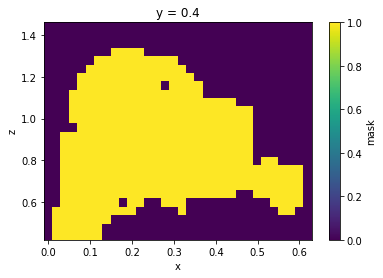

In [21]:
volume.mask[:,20].T.plot()

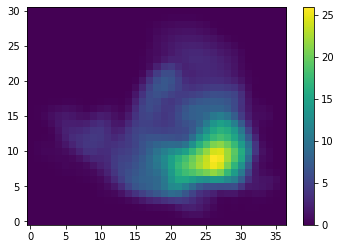

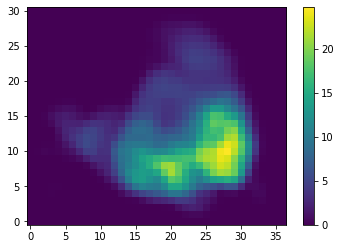

In [12]:
reference, other = shdom.util.cell_average_comparison(
                                   list(solvers_reconstruct.values())[0].medium['cloud'],
    list(solvers.values())[0].medium['cloud'],
                                  'extinction')

py.figure()
py.imshow(reference[...].mean(axis=-1),origin='lower')
py.colorbar()
py.figure()
py.imshow(other[...].mean(axis=-1),origin='lower')
py.colorbar()

In [17]:
print(reference.mean(), other.mean(), np.mean(reference-other)/np.mean(other))

2.8028031021608886 3.168388596087244 -0.11538530796942983


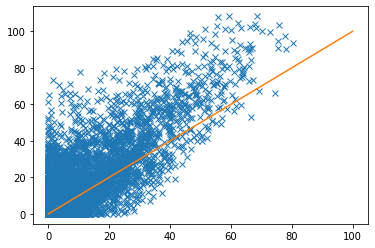

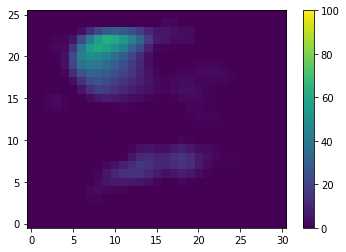

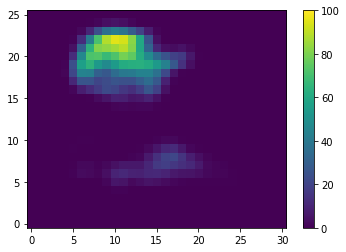

In [11]:
reference, other = shdom.util.cell_average_comparison(
                                   list(solvers_reconstruct.values())[0].medium['cloud'],
    list(solvers.values())[0].medium['cloud'],
                                  'extinction')

py.figure()
py.plot(reference.ravel(), other.ravel(),'x')
py.plot([0,100],[0,100])

py.figure()
py.imshow(reference[:,30].T,origin='lower',vmax=100)
py.colorbar()
py.figure()
py.imshow(other[:,30].T,origin='lower',vmax=100)
py.colorbar()

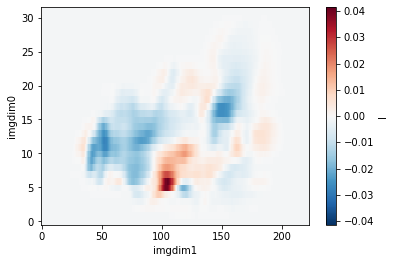

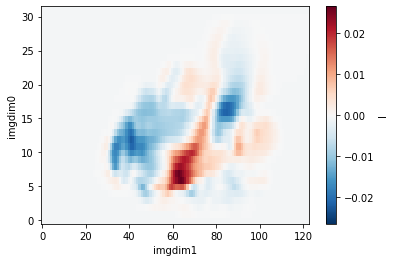

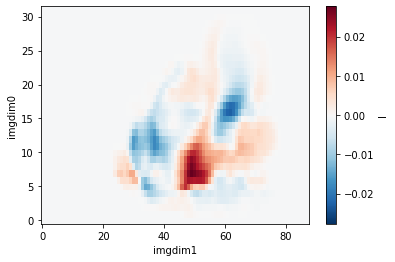

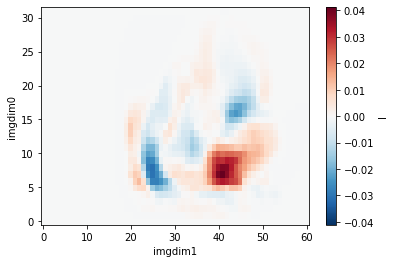

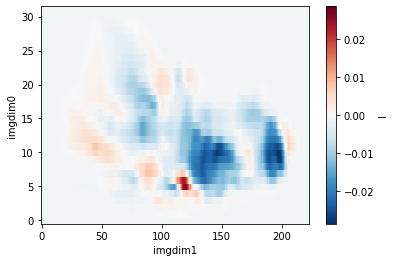

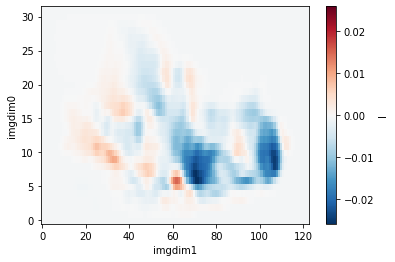

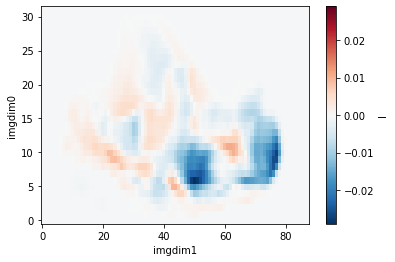

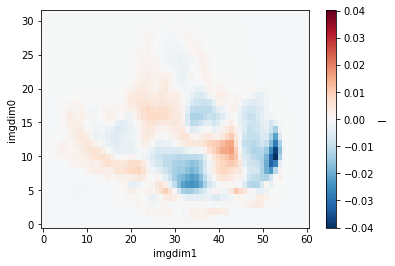

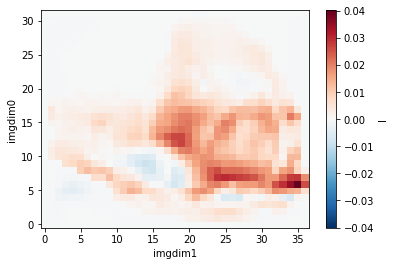

In [14]:
for i in range(9):
    py.figure()
    (forward_sensors.get_image('MISR',i).I - sensor_dict.get_image('MISR',i).I).plot()

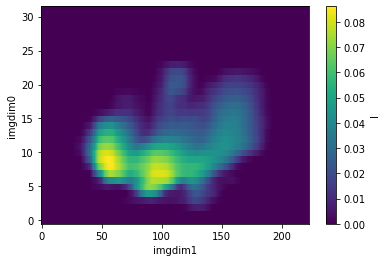

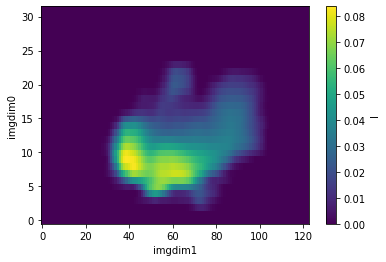

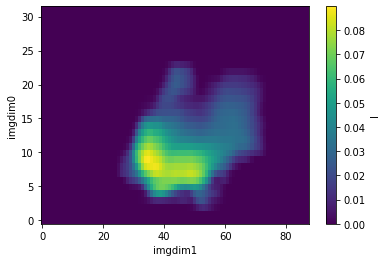

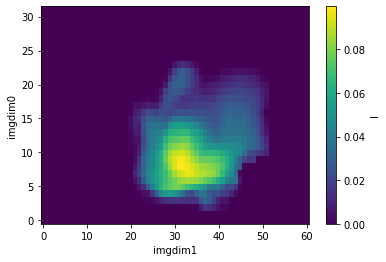

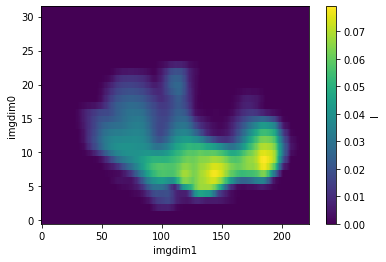

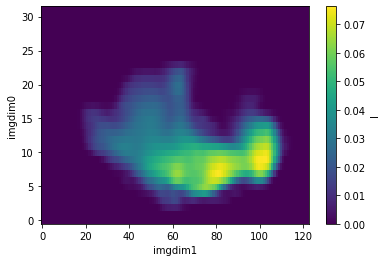

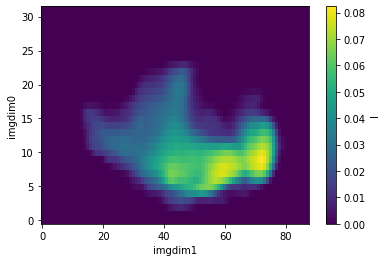

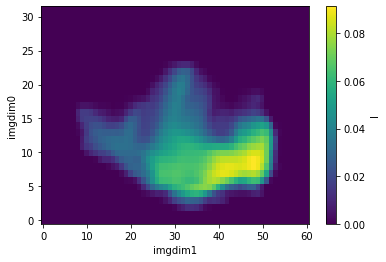

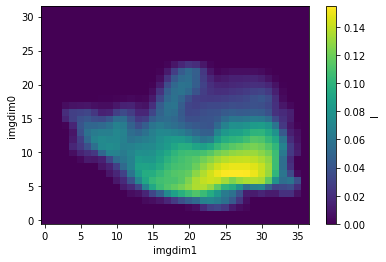

In [33]:
for i in range(9):
    py.figure()
    (forward_sensors.get_image('MISR',i).I).plot()

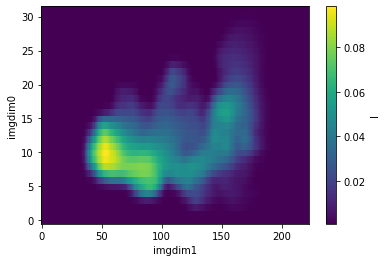

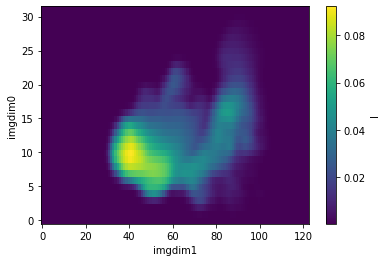

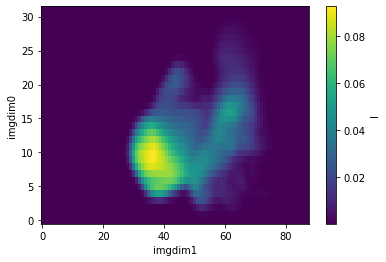

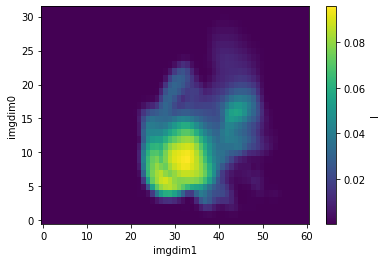

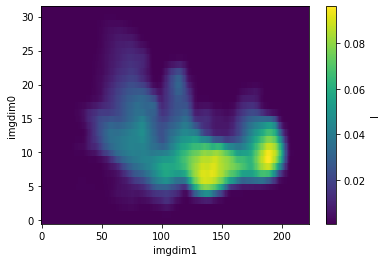

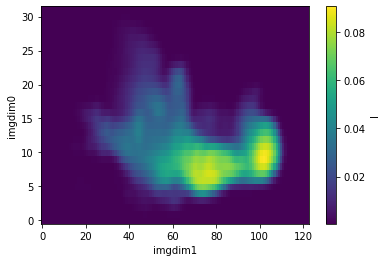

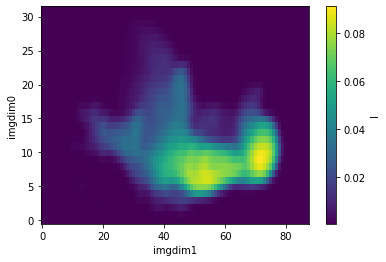

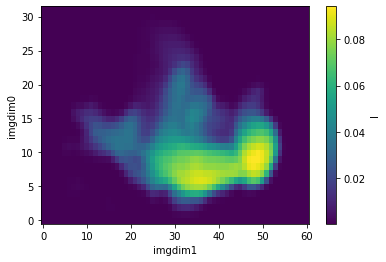

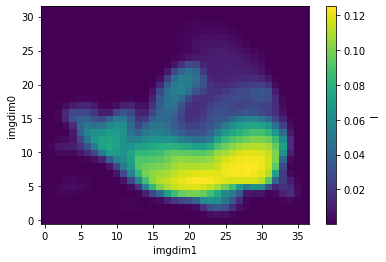

In [34]:
for i in range(9):
    py.figure()
    sensor_dict.get_image('MISR',i).I.plot()

In [9]:
np.tile(np.linspace(2.5,65.0,30),2)

array([ 2.5       ,  4.65517241,  6.81034483,  8.96551724, 11.12068966,
       13.27586207, 15.43103448, 17.5862069 , 19.74137931, 21.89655172,
       24.05172414, 26.20689655, 28.36206897, 30.51724138, 32.67241379,
       34.82758621, 36.98275862, 39.13793103, 41.29310345, 43.44827586,
       45.60344828, 47.75862069, 49.9137931 , 52.06896552, 54.22413793,
       56.37931034, 58.53448276, 60.68965517, 62.84482759, 65.        ,
        2.5       ,  4.65517241,  6.81034483,  8.96551724, 11.12068966,
       13.27586207, 15.43103448, 17.5862069 , 19.74137931, 21.89655172,
       24.05172414, 26.20689655, 28.36206897, 30.51724138, 32.67241379,
       34.82758621, 36.98275862, 39.13793103, 41.29310345, 43.44827586,
       45.60344828, 47.75862069, 49.9137931 , 52.06896552, 54.22413793,
       56.37931034, 58.53448276, 60.68965517, 62.84482759, 65.        ])

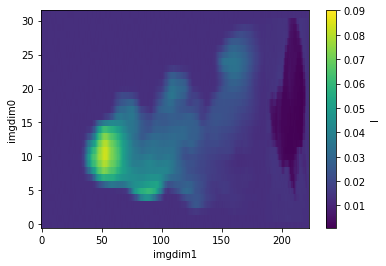

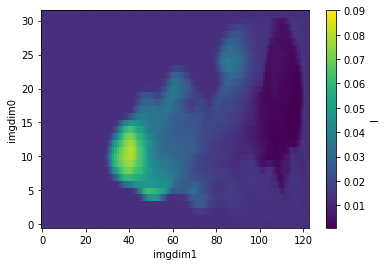

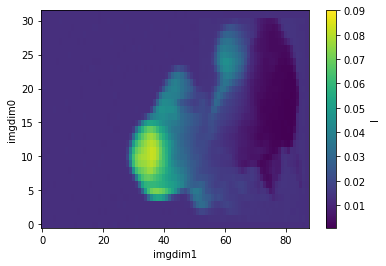

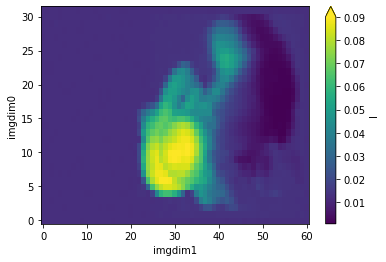

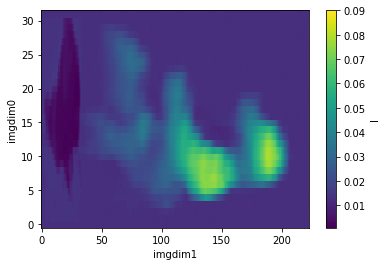

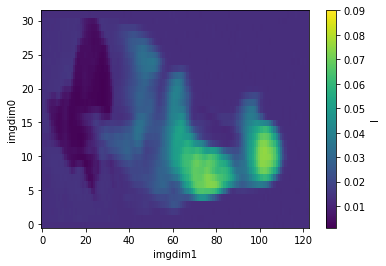

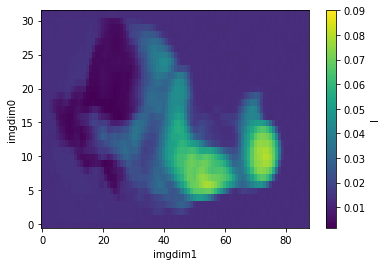

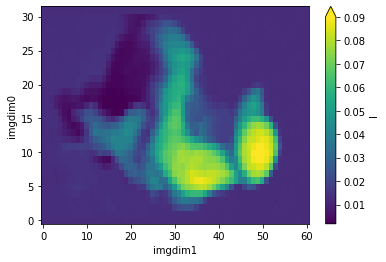

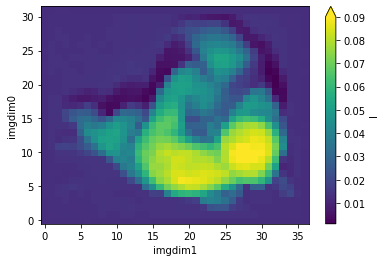

In [6]:
for i in range(9):
    py.figure()
    sensor_dict.get_image('MISR',i).I.plot(vmax=0.09)

In [11]:
sensor.I.data.min()

0.0010199785

In [ ]:
import tensorboardX

class SummaryWriter(tensorboardX.SummaryWriter):
    def __init__(self, logdir=None, comment='', purge_step=None, max_queue=10, flush_secs=120,
                 filename_suffix='', write_to_disk=True, **kwargs):
        super().__init__(logdir, comment, purge_step, max_queue, flush_secs,
                         filename_suffix, write_to_disk, **kwargs)

In [ ]:
a,b,c = np.where(self.cloud_mask==1)
a,b,c = (a/self.nx)*self.domain_size, b/self.ny*self.domain_size, c/self.nz*self.domain_size*self.aspect_ratio
no_cloud_positions = np.stack((a,b,c),axis=1)
tree = cKDTree(no_cloud_positions)

q,w,e = np.where(self.cloud_mask==0)
q2,w2,e2 = (q/self.nx)*self.domain_size, w/self.ny*self.domain_size, e/self.nz*self.domain_size*self.aspect_ratio
cloud_positions = np.stack((q2,w2,e2),axis=1)
d,i = tree.query(cloud_positions)



In [ ]:
from scipy.spatial import cKDTree
distance = np.zeros((x.shape))
x,y,z = np.meshgrid(rte_grid.x.data, rte_grid.y.data,rte_grid.z.data, indexing='ij')
no_cloud_positions = np.stack((x[np.bitwise_not(mask)],y[np.bitwise_not(mask)]),axis=1)
cloud_positions = np.stack((x[mask],y[mask]),axis=1)
tree = cKDTree(no_cloud_positions)
d,i = tree.query(cloud_positions)

In [ ]:
cloud_positions

In [ ]:
solvers[0.86].medium['cloud'].extinction.interp_like(rte_grid).fillna(0.0)[:,20].plot()

In [ ]:
d

In [ ]:
distance = np.zeros((x.shape))
distance[mask] = d
py.figure()
py.imshow(distance[12])
py.show()

In [ ]:
from scipy.spatial import cKDTree

tree = cKDTree(no_cloud_positions)

In [ ]:
weights.volume[21].plot()

In [ ]:
gradient1 = np.zeros(volume.volume.shape)
gradient1[mask] = gradient
py.figure()
py.imshow(gradient1[:,23])
py.colorbar()